In [21]:
import logging
import os
import random
import warnings
from datetime import datetime
from pathlib import Path
import time 
from random import SystemRandom
import pandas as pd

from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
from torch import Tensor, jit
from utils import get_data_loaders

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
# torch.jit.enable_onednn_fusion(True)
torch.backends.cudnn.benchmark = True

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"



def MSE(y: Tensor, yhat: Tensor, mask: Tensor) -> Tensor:
    err = torch.sum(mask*((y - yhat)**2)) / torch.sum(mask)
    return err

METRICS = {
   # "RMSE": jit.script(RMSE),
    "MSE": jit.script(MSE),
    #"MAE": jit.script(MAE),
}
LOSS = jit.script(MSE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = "cuda"
INPUT_DIM = 2
experiment_id = 0

print(DEVICE)
np.random.seed(0)
torch.manual_seed(0)

cpu


In [22]:
# Cell A: USHCN preprocessing
from tsdm.datasets import USHCN_DeBrouwer2019 as USHCN_DS
from tsdm.tasks.ushcn.ushcn_debrouwer2019 import USHCN_DeBrouwer2019

ds = USHCN_DS()  # triggers data download/caching
task = USHCN_DeBrouwer2019(normalize_time=True)
df = task.dataset.reset_index()
print(f"Unique stations: {df.ID.nunique()}, time-points per station stats:")
print(df.groupby('ID').Time.count().describe())


Unique stations: 1114, time-points per station stats:
count        1114.0
mean     314.780072
std       41.488772
min            18.0
25%           308.0
50%           323.0
75%           337.0
max           370.0
Name: Time, dtype: double[pyarrow]


/Users/ixdlab/masterthesis/tsdm/datasets/base.py:529: UserWarning: /Users/ixdlab/.tsdm/datasets/USHCN_DeBrouwer2019/USHCN_DeBrouwer2019.parquet ✘✘ refusing to validate, since parquet is not binary stable! Hash sha256:f492d577439c1a9f0e17bbc155024fcb4030eba6970a20006ce210583203eeaf
  validate_file_hash(self.dataset_path, self.dataset_hash)
/Users/ixdlab/masterthesis/tsdm/datasets/base.py:529: UserWarning: /Users/ixdlab/.tsdm/datasets/USHCN_DeBrouwer2019/USHCN_DeBrouwer2019.parquet ✘✘ refusing to validate, since parquet is not binary stable! Hash sha256:f492d577439c1a9f0e17bbc155024fcb4030eba6970a20006ce210583203eeaf
  validate_file_hash(self.dataset_path, self.dataset_hash)
/Users/ixdlab/masterthesis/tsdm/datasets/base.py:529: UserWarning: /Users/ixdlab/.tsdm/datasets/USHCN_DeBrouwer2019/USHCN_DeBrouwer2019.parquet ✘✘ refusing to validate, since parquet is not binary stable! Hash sha256:f492d577439c1a9f0e17bbc155024fcb4030eba6970a20006ce210583203eeaf
  validate_file_hash(self.dataset_pa

In [23]:
# Cell B: MIMIC-III preprocessing
from tsdm.datasets import MIMIC_III_DeBrouwer2019 as M3_DS
from tsdm.tasks.mimic.mimic_iii_debrouwer2019 import MIMIC_III_DeBrouwer2019

m3 = M3_DS()  # download + cache
task3 = MIMIC_III_DeBrouwer2019(condition_time=36, forecast_horizon=12)
data3 = task3.dataset.reset_index()
print("MIMIC-III raw records:", len(data3))
print("Per-patient time points stats:")
print(data3.groupby('ID')['Time'].count().describe())


RuntimeError: Please manually apply the preprocessing code found at https://github.com/edebrouwer/gru_ode_bayes/.
Put the resulting file 'complete_tensor.csv' in /Users/ixdlab/.tsdm/rawdata/MIMIC_III_DeBrouwer2019.
The cleaning code is not included in this package because the original.
authors did not provide a license for it.

In [24]:
# Cell C: MIMIC-IV preprocessing
from tsdm.datasets import MIMIC_IV_Bilos2021 as M4_DS
from tsdm.tasks.mimic.mimic_iv_bilos2021 import MIMIC_IV_Bilos2021

m4 = M4_DS()
task4 = MIMIC_IV_Bilos2021(condition_time=36, forecast_horizon=12)
data4 = task4.dataset.reset_index()
print("MIMIC-IV raw records:", len(data4))
print("Per-patient record lengths:")
print(data4.groupby('ID')['Time'].count().describe())


RuntimeError: Please manually apply the preprocessing code found at https://github.com/mbilos/neural-flows-experiments.
Put the resulting file 'complete_tensor.csv' in /Users/ixdlab/.tsdm/rawdata/MIMIC_IV_Bilos2021.
The cleaning code is not included in this package because the original.
authors did not provide a license for it.

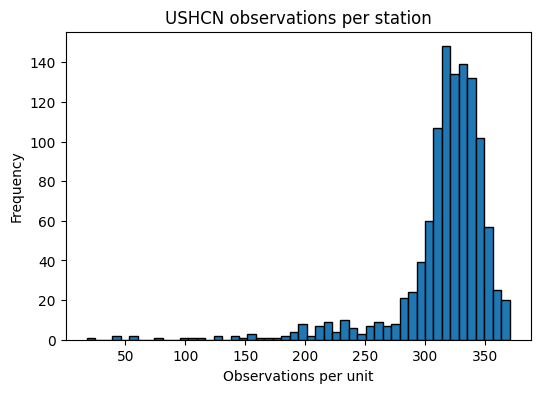

In [25]:
import matplotlib.pyplot as plt

def plot_counts(df, id_col='ID', time_col='Time', title=None):
    counts = df.groupby(id_col)[time_col].count()
    plt.figure(figsize=(6,4))
    plt.hist(counts, bins=50, edgecolor='k')
    plt.title(title)
    plt.xlabel('Observations per unit')
    plt.ylabel('Frequency')
    plt.show()

plot_counts(df, 'ID', 'Time', 'USHCN observations per station')
# plot_counts(data3, 'ID', 'Time', 'MIMIC‑III observations per patient')
# plot_counts(data4, 'ID', 'Time', 'MIMIC‑IV observations per patient')



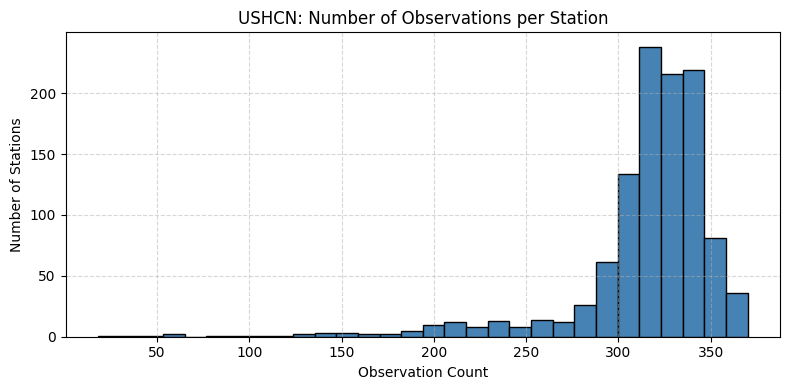

In [26]:
import matplotlib.pyplot as plt

counts = df.groupby('ID')['Time'].count()
plt.figure(figsize=(8, 4))
plt.hist(counts, bins=30, edgecolor='black', color='steelblue')
plt.title("USHCN: Number of Observations per Station")
plt.xlabel("Observation Count")
plt.ylabel("Number of Stations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [27]:

import argparse
import os
import random
import time
from datetime import datetime
from pathlib import Path
import numpy as np
import torch
from torch import Tensor, jit
from torch.utils.data import DataLoader
from torch.optim import AdamW

from tsdm.tasks.ushcn.ushcn_debrouwer2019 import USHCN_DeBrouwer2019, ushcn_collate

class Args:
    fold = 0
    batch_size = 64
    learn_rate = 1e-4
    weight_decay = 1e-3
    latent_dim = 20
    embedding_dim = 4
    num_heads = 2
    function = "C"
    depth = 1
    seed = 42
    dataset = "ushcn"
    epochs = 300
    early_stop = 30

ARGS = Args()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [28]:
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class FLDAttention(nn.Module):
    def __init__(
        self,
        input_dim,
        parameters,
        latent_dim=16,
        embed_dim=16,
        num_heads=2,
        shared_out=True,
    ):
        super(FLDAttention, self).__init__()
        assert embed_dim % num_heads == 0
        self.embed_time = embed_dim
        self.embed_time_k = embed_dim // num_heads
        self.h = num_heads
        self.nhidden = latent_dim
        if shared_out:
            self.out = nn.Sequential(nn.Linear(input_dim * num_heads, latent_dim))
        else:
            self.out = nn.Parameter(
                torch.randn(1, parameters, input_dim * num_heads, latent_dim)
            )
            self.out_bias = nn.Parameter(torch.zeros(1, parameters, latent_dim))
        self.shared = shared_out

        self.query_map = nn.Linear(embed_dim, embed_dim)
        self.key_map = nn.Linear(embed_dim, embed_dim)

    def attention(self, query, key, value, mask=None):
        "Compute 'Scaled Dot Product Attention'"
        dim = value.size(-1)
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        # BS x H x P x T
        scores = scores.unsqueeze(-1).repeat_interleave(
            dim, dim=-1
        )  # BS x H x P x T x D
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(-3) == 0, -1e9)
        p_attn = F.softmax(scores, dim=-2)
        return torch.sum(p_attn * value.unsqueeze(-3), -2), p_attn  # BS x H x P x D

    def forward(self, query, key, value, mask=None):
        "Compute 'Scaled Dot Product Attention'"
        batch, seq_len, dim = value.size()
        if mask is not None:
            mask = mask.unsqueeze(1)
        value = value.unsqueeze(1)
        query = self.query_map(query)
        key = self.key_map(key)
        query, key = [
            x.view(x.size(0), -1, self.h, self.embed_time_k).transpose(1, 2)
            for x in (query, key)
        ]
        # (BS: Batch-Size, H = number of attention heads, P = number of Parameters, D = input dim, = HD latent dimension)

        x, _ = self.attention(query, key, value, mask)  #  BS x H x P x D
        x = x.transpose(1, 2).contiguous().view(batch, -1, self.h * dim)  # BS x P x HD
        if self.shared:
            return self.out(x)
        else:
            x = x.unsqueeze(-2) @ self.out  # BS x P x 1 x L
            x = x.squeeze(-2) + self.out_bias
            return x  # BS x P x L


class FLD(nn.Module):
    def __init__(
        self,
        input_dim,
        latent_dim,
        embed_dim_per_head,
        num_heads,
        function,
        device,
        depth=1,
        hidden_dim=None,
        shared_out_for_attn=True,
    ) -> None:
        super(FLD, self).__init__()
        if function == "C":
            P = 1
        elif function == "L":
            P = 2
        elif function == "Q":
            P = 3
        elif function == "S":
            P = 4
        self.F = function
        embed_dim = embed_dim_per_head * num_heads
        self.attn = FLDAttention(
            input_dim=2 * input_dim,
            latent_dim=latent_dim,
            embed_dim=embed_dim,
            num_heads=num_heads,
            parameters=P,
            shared_out=shared_out_for_attn,
        )
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.time_embedding = nn.Linear(1, embed_dim)
        self.query = nn.Parameter(torch.randn(1, P, embed_dim))
        if not hidden_dim:
            hidden_dim = latent_dim
        if depth > 0:
            decoder = [nn.Linear(latent_dim, hidden_dim), nn.ReLU()]
            for i in range(depth - 1):
                decoder.append(nn.Linear(hidden_dim, hidden_dim))
                decoder.append(nn.ReLU())
            decoder.append(nn.Linear(hidden_dim, input_dim))
        if depth == 0:
            decoder = [nn.Linear(latent_dim, input_dim)]
        self.out = nn.Sequential(*decoder)
        self.device = device
        self.latent_dim = latent_dim

    def learn_time_embedding(self, tt):
        tt = tt.to(self.device)
        tt = tt.unsqueeze(-1)
        inds = []
        for i in range(self.embed_dim):
            if i % self.num_heads == 0:
                inds.append(i)
        out = self.time_embedding(tt)
        out[:, :, inds] = torch.sin(out[:, :, inds])
        return out

    def forward(self, timesteps, X, M, y_time_steps):
        key = self.learn_time_embedding(timesteps).unsqueeze(1)
        X = torch.cat((X, M), -1)
        M = torch.cat((M, M), -1)
        coeffs = self.attn(self.query, key, X, M)
        if self.F == "C":
            x = (
                coeffs[:, 0, :]
                .unsqueeze(-2)
                .repeat_interleave(y_time_steps.size()[1], -2)
            )
        if self.F == "Q":
            x = (
                coeffs[:, 0, :].unsqueeze(-2)
                + ((y_time_steps).unsqueeze(-1) @ coeffs[:, 1, :].unsqueeze(-2))
                + (((y_time_steps).unsqueeze(-1) ** 2) @ coeffs[:, 2, :].unsqueeze(-2))
            )

        if self.F == "L":
            x = coeffs[:, 0, :].unsqueeze(-2) + (
                (y_time_steps).unsqueeze(-1) @ coeffs[:, 1, :].unsqueeze(-2)
            )
        if self.F == "S":
            x = (
                coeffs[:, 0].unsqueeze(-2)
                * torch.sin(
                    (coeffs[:, 1].unsqueeze(-2) * y_time_steps.unsqueeze(-1))
                    + coeffs[:, 2].unsqueeze(-2)
                )
            ) + coeffs[:, 3].unsqueeze(-2)
        return self.out(x)


In [29]:

torch.manual_seed(ARGS.seed)
np.random.seed(ARGS.seed)
random.seed(ARGS.seed)

TASK = USHCN_DeBrouwer2019()
INPUT_DIM = 5

def MSE(y, yhat, mask):
    denom = torch.sum(mask)
    if denom == 0:
        return torch.tensor(0.0, device=y.device)
    print("Mask sum:", mask.sum().item())

    return torch.sum(mask * (y - yhat) ** 2) / denom
LOSS = jit.script(MSE)

def predict_fn(model, batch):
    T, X, M, TY, Y, MY = (tensor.to(DEVICE) for tensor in batch)
    return Y, model(T, X, M, TY), MY
from src.models.FLD import FLD

MODEL = FLD(
    input_dim=INPUT_DIM,
    latent_dim=ARGS.latent_dim,
    embed_dim_per_head=ARGS.embedding_dim,
    num_heads=ARGS.num_heads,
    function=ARGS.function,
    depth=ARGS.depth,
    device=DEVICE,
).to(DEVICE)

dloader_config = lambda shuffle: {
    "batch_size": ARGS.batch_size if shuffle else 64,
    "shuffle": shuffle,
    "drop_last": shuffle,
    "pin_memory": True,
    "num_workers": 0 if not shuffle else 4,
    "collate_fn": ushcn_collate,
}

TRAIN_LOADER = TASK.make_dataloader((ARGS.fold, "train"), **dloader_config(True))
VALID_LOADER = TASK.make_dataloader((ARGS.fold, "valid"), **dloader_config(False))
TEST_LOADER = TASK.make_dataloader((ARGS.fold, "test"), **dloader_config(False))


/Users/ixdlab/masterthesis/tsdm/datasets/base.py:529: UserWarning: /Users/ixdlab/.tsdm/datasets/USHCN_DeBrouwer2019/USHCN_DeBrouwer2019.parquet ✘✘ refusing to validate, since parquet is not binary stable! Hash sha256:f492d577439c1a9f0e17bbc155024fcb4030eba6970a20006ce210583203eeaf
  validate_file_hash(self.dataset_path, self.dataset_hash)
/Users/ixdlab/masterthesis/tsdm/datasets/base.py:529: UserWarning: /Users/ixdlab/.tsdm/datasets/USHCN_DeBrouwer2019/USHCN_DeBrouwer2019.parquet ✘✘ refusing to validate, since parquet is not binary stable! Hash sha256:f492d577439c1a9f0e17bbc155024fcb4030eba6970a20006ce210583203eeaf
  validate_file_hash(self.dataset_path, self.dataset_hash)


In [30]:

OPTIMIZER = AdamW(MODEL.parameters(), lr=ARGS.learn_rate, weight_decay=ARGS.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, "min", patience=10, factor=0.5, min_lr=5e-4)

EARLY_STOP, times, best_val, early_stop = ARGS.early_stop, [], float("inf"), 0
for epoch in range(1, ARGS.epochs + 1):
    MODEL.train()
    train_loss = torch.tensor([LOSS(*predict_fn(MODEL, batch)) for batch in TRAIN_LOADER]).mean()

    MODEL.eval()
    with torch.no_grad():
        val_loss = sum(LOSS(*predict_fn(MODEL, batch)) * batch[-1].sum() for batch in VALID_LOADER)
        val_loss /= sum(batch[-1].sum() for batch in VALID_LOADER)

    print(f"Epoch {epoch}: Train={train_loss:.4f} Val={val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        early_stop = 0
        torch.save({"state_dict": MODEL.state_dict()}, "fld_ushcn_best.pt")
    else:
        early_stop += 1
    if early_stop >= EARLY_STOP:
        print(f"Early stopping at epoch {epoch}")
        break
    scheduler.step(val_loss)


/Users/ixdlab/miniconda3/envs/fld-thesis/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RuntimeError: Broken pipe

In [17]:
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)
